Namespace(params='2nd_order_2D', results_base_directory='./results', simulation_steps=3000, sample=10, use_model='true')
Data preprocessing, demonstration 1 / 1
Mean error spline resampling: 9.755965566654589e-17


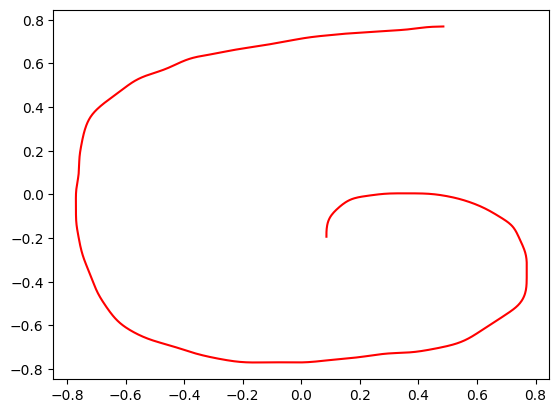

In [1]:
import importlib
import numpy as np
import torch
from simple_parsing import ArgumentParser
from data_preprocessing.data_preprocessor import DataPreprocessor
import matplotlib.pyplot as plt
from agent.utils.utils import *
# -------------------------
# 1. Define arguments
# -------------------------
parser = ArgumentParser()
parser.add_argument('--params', type=str, default='2nd_order_2D')
parser.add_argument('--results-base-directory', type=str, default='./')
parser.add_argument('--simulation-steps', type=int, default=5500)
parser.add_argument('--sample', type=int, default=25)
parser.add_argument('--use-model', type=str, default='false', choices=['true', 'false'])

# -------------------------
# 2. In Notebook: manually set the args
# -------------------------
notebook_args = [
    "--params", "2nd_order_2D",
    "--results-base-directory", "./results",
    "--simulation-steps", "3000",
    "--sample", "10",
    "--use-model", "true"
]

args, unknown = parser.parse_known_args(notebook_args)

print(args)

Params = getattr(importlib.import_module('params.' + args.params), 'Params')
params = Params(args.results_base_directory)
params.selected_primitives_ids = str(7)

data_preprocessor = DataPreprocessor(params=params, verbose=True)
data = data_preprocessor.run()

# Extract relevant data
# demonstrations = data['demonstrations raw']
demonstrations_norm = data['demonstrations train'][:,:,:,0]



demonstrations_norm = lpf_demonstrations(demonstrations_norm,
                                    fs=1.0,   # if samples are unit-spaced
                                    L_min=30, # remove variations shorter than 30 samples
                                    order=4)
plt.plot(demonstrations_norm[0,:,0],demonstrations_norm[0,:,1], 'r')

In [15]:
from agent.utils.R2_functions import gvf_R2_np 
from scipy.interpolate import splprep, splev

demo_start_point = demonstrations_norm[0,0,:]
goal = demonstrations_norm[0,-1,:]

start_point_1 = demo_start_point + np.array([0.0, 0.1])
start_point_2 = demo_start_point + np.array([0.0, -0.1])

start_point = np.array([start_point_1, start_point_2])

velocity = (demonstrations_norm[:, 1:, :] - demonstrations_norm[:, :-1, :])/ params.delta_t            
velocity = np.concatenate((velocity ,np.zeros((velocity.shape[0], 1, params.workspace_dimensions))), axis=1)  # Add zero velocity for last point

result = []
dist_result = []
velocity_result = []

for state in start_point:
    xtraj = demonstrations_norm
    xdottraj = velocity
    
    state = np.expand_dims(state, axis=0)
    traj = []
    dist_list = []
    velocity_list = []
    
    for _ in range(args.simulation_steps):
        velocities, dist = gvf_R2_np(state, 1e-2 , xtraj, xdottraj, 'normal', [5.0])
        
        state = state + velocities * params.delta_t
        traj.append(state)
        dist_list.append(dist)
        velocity_list.append(velocities)
        
        # Goal 도달 시 조기 종료
        if np.linalg.norm(state - goal) < 0.01:
            print("Reached the goal!")
            break
            
    result.append(np.array(traj))
    dist_result.append(np.array(dist_list))
    velocity_result.append(np.array(velocity_list))

# ---------------------------------------------------------
# [2] 후처리: 궤적 파라미터화 및 곡률 계산 함수 (Spline 기반)
# ---------------------------------------------------------
def compute_curvature_spline(trajectory):
    """
    trajectory: (N, 1, 2) or (N, 2) numpy array
    returns: curvature array (N,)
    """
    # 차원 정리: (N, 1, 2) -> (N, 2) -> x, y 분리
    points = trajectory.squeeze() 
    # print(points.shape)
    x = points[:, 0]
    y = points[:, 1]
    
    # 데이터가 너무 적으면 계산 불가 (Spline fit을 위해 최소 4점 필요)
    if len(x) < 4:
        return np.zeros_like(x)

    # 1. B-Spline Fitting (Parametric)
    # s: smoothing factor (0이면 모든 점을 지남, 약간 주면 노이즈 제거됨)
    # k=3: Cubic Spline (3차 곡선 -> 2번 미분 가능)
    try:
        tck, u = splprep([x, y], s=0.01, k=3)
    except Exception as e:
        print(f"Spline fitting failed: {e}")
        return np.zeros_like(x)

    # 2. 해석적 미분 (Analytical Derivatives)
    # der=1: 1차 미분 (속도 벡터 성분: x', y')
    dx, dy = splev(u, tck, der=1)
    # der=2: 2차 미분 (가속도 벡터 성분: x'', y'')
    ddx, ddy = splev(u, tck, der=2)
    
    # 3. 곡률 공식 적용: k = (x'y'' - y'x'') / (x'^2 + y'^2)^(3/2)
    numerator = dx * ddy - dy * ddx
    denominator = (dx**2 + dy**2)**1.5
    
    # 분모 0 방지 및 계산
    curvature = np.zeros_like(dx)
    valid_mask = denominator > 1e-8
    curvature[valid_mask] = numerator[valid_mask] / denominator[valid_mask]
    
    return curvature

# ---------------------------------------------------------
# [3] 곡률 계산 실행
# ---------------------------------------------------------
curvature_result = []
for traj_data in result:
    k = compute_curvature_spline(traj_data)
    curvature_result.append(k)
    
demo_curvature = compute_curvature_spline(demonstrations_norm[0,:,:])
curvature_result.append(demo_curvature)

Reached the goal!
Reached the goal!


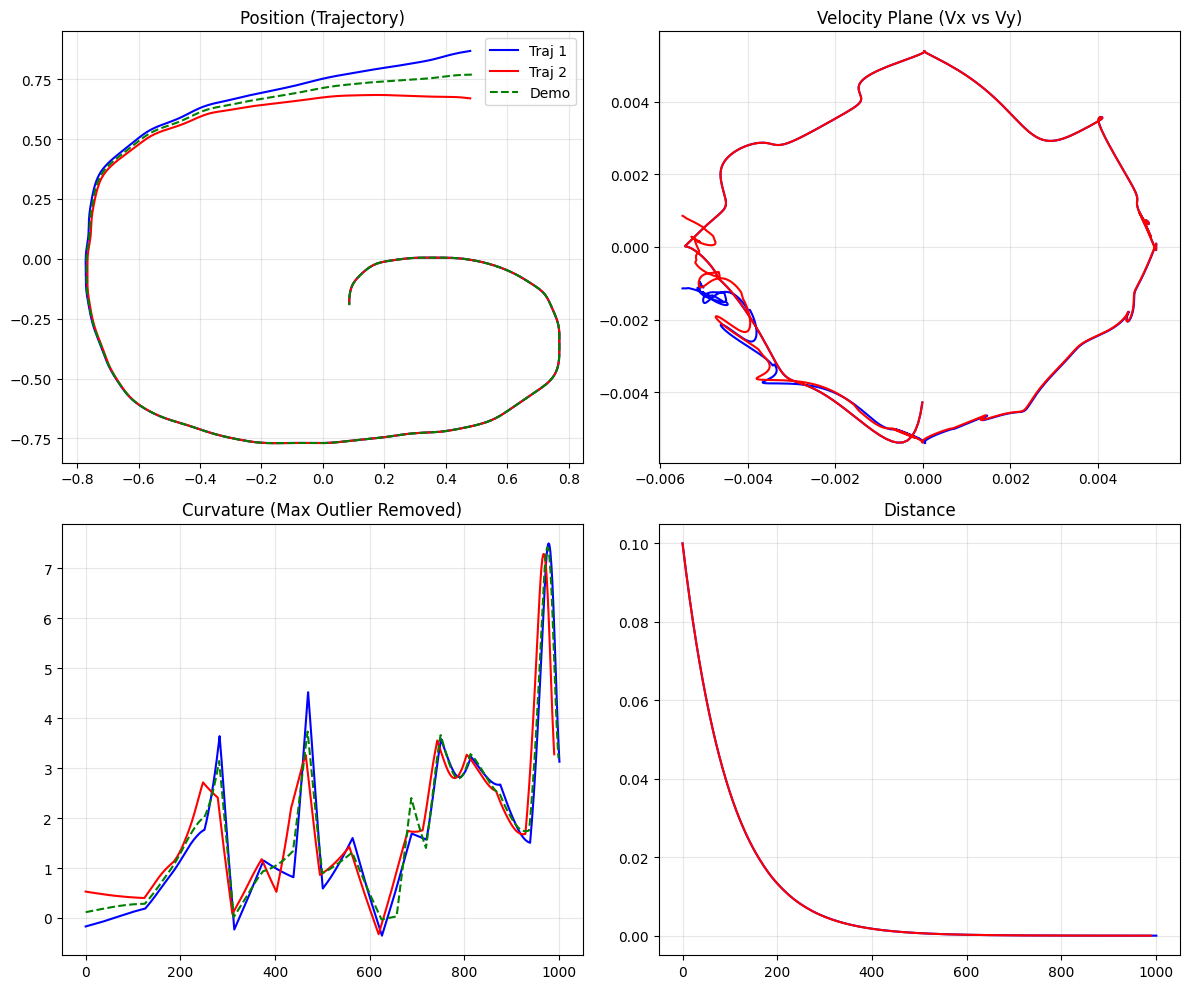

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# 2x2 서브플롯 생성 (크기 조절: figsize=(12, 10))
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ---------------------------
# 1. Position (좌측 상단: axes[0, 0])
# ---------------------------
ax_pos = axes[0, 0]
ax_pos.plot(result[0][:,:,0], result[0][:,:,1], 'b', label='Traj 1')
ax_pos.plot(result[1][:,:,0], result[1][:,:,1], 'r', label='Traj 2')
ax_pos.plot(demonstrations_norm[0,:,0], demonstrations_norm[0,:,1], 'g--', label='Demo')
ax_pos.set_title('Position (Trajectory)')
ax_pos.legend()
ax_pos.grid(True, alpha=0.3)

# ---------------------------
# 2. Velocity (우측 상단: axes[0, 1])
# ---------------------------
ax_vel = axes[0, 1]
ax_vel.plot(velocity_result[0][:,:,0], velocity_result[0][:,:,1], 'b')
ax_vel.plot(velocity_result[1][:,:,0], velocity_result[1][:,:,1], 'r')
ax_vel.set_title('Velocity Plane (Vx vs Vy)')
ax_vel.grid(True, alpha=0.3)

# ---------------------------
# 3. Curvature (좌측 하단: axes[1, 0]) - 이상치 제거 로직 포함
# ---------------------------
ax_cur = axes[1, 0]

# 원본 보존을 위한 copy
curv_1 = curvature_result[0].copy()
curv_2 = curvature_result[1].copy()
curv_demo = curvature_result[2].copy()

# (1) 첫 번째 궤적 최대값(절대값) 1개 제거
# max_idx_1 = np.argmax(np.abs(curv_1))
# curv_1[max_idx_1] = np.nan 

# # (2) 두 번째 궤적 최대값(절대값) 1개 제거
# max_idx_2 = np.argmax(np.abs(curv_2))
# curv_2[max_idx_2] = np.nan

# print(f"Removed Max Index - Traj1: {max_idx_1}, Traj2: {max_idx_2}")

ax_cur.plot(curv_1, 'b')
ax_cur.plot(curv_2, 'r')
ax_cur.plot(curv_demo, 'g--')
ax_cur.set_title('Curvature (Max Outlier Removed)')
ax_cur.grid(True, alpha=0.3)

# ---------------------------
# 4. Distance (우측 하단: axes[1, 1])
# ---------------------------
ax_dist = axes[1, 1]
ax_dist.plot(dist_result[0], 'b')
ax_dist.plot(dist_result[1], 'r')
ax_dist.set_title('Distance')
ax_dist.grid(True, alpha=0.3)

# 레이아웃 간격 자동 조절 및 출력
plt.tight_layout()
plt.show()

In [10]:
curvature_result[1][1010:1020]

array([], dtype=float64)